<a href="https://colab.research.google.com/github/EmilisGit/Deep_learning/blob/main/bert_finetuning_with_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install transformers==4.47.0 datasets==3.2.0 -q

In [31]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import transformers
import os
import datasets
from transformers import DataCollatorForSeq2Seq

from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
print("Transformers " + transformers.__version__)
print("Datasets " + datasets.__version__)

Transformers 4.47.0
Datasets 3.2.0


In [32]:
#@title Import Dataset
hfDataset = load_dataset("ambrosfitz/10k_history_summary")
split = hfDataset['train'].train_test_split(test_size=0.2)
hfDataset['train'] = split['train'].shuffle(seed=42).select(range(3000))
hfDataset['test'] = split['test'].shuffle(seed=42).select(range(300))

hfDataset.save_to_disk("/content/hfDataset")

Saving the dataset (0/1 shards):   0%|          | 0/3000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

In [33]:
INPUT_NAME = "text"
OUTPUT_NAME = "target"
hfDataset['train'][0]

{'text': "In colonial New England, the concept of property rights was a contentious issue, particularly when it came to the land originally inhabited by Indigenous peoples. Colonists justified their conquest of these lands by asserting that ownership was based on improvements made through cultivation and husbandry. Roger Williams challenged this notion, arguing that the indigenous peoples had a legitimate claim to the land by virtue of their first occupancy and the ecological changes they had brought about, such as burning the underwoods for hunting purposes. Williams's opponents countered by highlighting the English Crown's services for the Commonwealth and the multiple uses of English lands, including timber cutting and cattle raising. The dispute over land ownership revealed a stark contrast in perspectives between Europeans and Indigenous peoples regarding the legitimacy of their respective ways of inhabiting and utilizing the land. The Europeans' refusal to acknowledge the rights 

In [34]:
import numpy as np
import math

input_lengths = [len(tokenizer.encode(sentence)) for sentence in hfDataset['train'][INPUT_NAME]]
output_lengths = [len(tokenizer.encode(sentence)) for sentence in hfDataset['train'][OUTPUT_NAME]]
print(f"Average input length: {math.floor(np.mean(input_lengths))}")
print(f"Max input length: {np.max(input_lengths)}")
print(f"Average output length: {math.floor(np.mean(output_lengths))}")
print(f"Max output length: {np.max(output_lengths)}")


Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors


Average input length: 216
Max input length: 540
Average output length: 82
Max output length: 301


In [35]:
# Load model directly
BASE_MODEL = "facebook/bart-base"
model = TFAutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [36]:
test_text = hfDataset['test'][INPUT_NAME][16]
test_text

"In August 1813, Jos Francisco Ruz, a thirty-year-old rancher living along the Nueces River south of San Antonio, Texas, sought asylum among the eastern Comanches. He had participated in Bernardo Gutirrez de Laras liberal rebellion against Spanish authority in Texas, aligning with the Hidalgo independence movement in Mexico. Following defeat by royalist forces at the Battle of the Medina River on August 18, 1813, Ruz evaded execution and spent the next eight years living, traveling, and likely raiding with Comanches supportive of the revolutionary cause. Engaging closely with Americans involved in the Plains trade along the eastern frontier, Ruz eventually received a full pardon from the new commandant general of the eastern Interior Provinces in the autumn of 1821 after Mexico gained independence from Spain. As a commissioner to the Comanches and Lipan Apaches on behalf of the new government, Ruz extended an invitation for a Comanche delegation to visit Mexico City and negotiate a tre

In [37]:
def Summarize_text(text):
    inference_text = tokenizer("Summarize: " + text, return_tensors="tf", max_length=600, padding="max_length", truncation=True)

    outputs = model.generate(
        input_ids=inference_text["input_ids"],
        attention_mask=inference_text["attention_mask"],
        max_length=100,
        early_stopping=True
    )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text
Summarize_text(test_text)

'Summarize: In August 1813, Jos Francisco Ruz, a thirty-year-old rancher living along the Nueces River south of San Antonio, Texas, sought asylum among the eastern Comanches. He had participated in Bernardo Gutirrez de Laras liberal rebellion against Spanish authority in Texas, aligning with the Hidalgo independence movement in Mexico. Following defeat by royalist forces at the Battle of the Medina River on August 18,1813, R'

In [38]:
def preprocess_data(examples):
    inputs = ["Summarize: " + ex for ex in examples[INPUT_NAME]]
    model_inputs = tokenizer(inputs, max_length=600, truncation=True, padding="max_length")
    model_inputs["input_ids"] = [inp for inp in model_inputs["input_ids"]]

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples[OUTPUT_NAME], max_length=100, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

encoded_dataset = hfDataset.map(preprocess_data, batched=True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

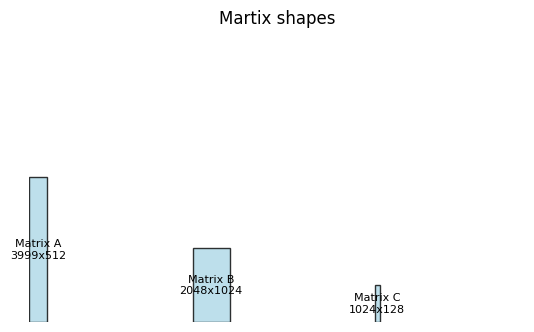

In [39]:
#@title Plot Matrices
def plot_matrices(matrices, labels=None, max_height=10, max_width=10):
    """
    Visualizes the shapes of large NumPy matrices as scaled rectangles.

    Parameters:
    - matrices: List of NumPy arrays
    - labels: Optional list of labels for the matrices
    - max_height: Maximum height of the largest rectangle in the plot
    - max_width: Maximum width of the largest rectangle in the plot
    """
    fig, ax = plt.subplots()
    current_x = 0

    # Determine scaling factors
    max_rows = max(matrix.shape[0] for matrix in matrices)
    max_cols = max(matrix.shape[1] for matrix in matrices)
    scale = max(max_rows, max_cols)

    for i, matrix in enumerate(matrices):
        rows, cols = matrix.shape
        scaled_rows = rows / scale
        scaled_cols = cols / scale

        # Draw rectangle
        rect = plt.Rectangle(
            (current_x, 0), scaled_cols, scaled_rows, edgecolor='black', facecolor='lightblue', alpha=0.8
        )
        ax.add_patch(rect)

        # Add label
        if labels and i < len(labels):
            ax.text(
                current_x + scaled_cols / 2, scaled_rows / 2,
                f"{labels[i]}\n{rows}x{cols}", ha='center', va='center', fontsize=8
            )

        current_x += scaled_cols + 1  # Add space between matrices

    # Set limits and display
    ax.set_xlim(0, current_x)
    ax.set_ylim(0, max(matrix.shape[0] / scale for matrix in matrices) + 1)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.xlabel('Columns (scaled)')
    plt.ylabel('Rows (scaled)')
    plt.title('Martix shapes')
    plt.show()

# Example usage with large matrices
matrices = [
    np.random.rand(3999, 512),
    np.random.rand(2048, 1024),
    np.random.rand(1024, 128)
]
labels = ["Matrix A", "Matrix B", "Matrix C"]
plot_matrices(matrices, labels)


Kiek turime apmokymo duomenų (mėginių)?

In [40]:
print("Apmokymo duomenu: ", len(hfDataset['train']))
print("Testavimo duomenu: ", len(hfDataset['test']))

Apmokymo duomenu:  3000
Testavimo duomenu:  300


Toliau naudosime tik dalį atsiliepimų viso proceso greitinimui:

In [41]:
training_data = encoded_dataset['train']
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors="tf")

tf_train_dataset = training_data.to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=8,
)

tf_train_dataset

<_PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(None, 600), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 600), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None, 100), dtype=tf.int64, name=None)}>

In [42]:
tf_train_dataset

<_PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(None, 600), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 600), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None, 100), dtype=tf.int64, name=None)}>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab/models/t5-summarization/Summarization_t5_eff_small_{epoch}.keras',
    save_freq='epoch',
    save_weights_only=True
)


model.compile(optimizer="adam")
model.fit(tf_train_dataset, epochs=3, callbacks=[checkpoint])

Pastebekime kad po tokenizavimo mūsų `Dataset` objectas gavo naujas savybes (stulpelius, raktažodžius) - `'input_ids'`, `'token_type_ids'` ir `'attention_mask'`:

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Colab/Summarization_t5_eff_small_v2.keras")

In [ ]:
test_text = hfDataset['test'][0]['text']
test_text

In [ ]:
Summarize_text(test_text)